In [ ]:
!pip install statsmodels

In [1]:
#Importar librerias
from gensim import corpora, models
import os
import re
import csv
import pandas as pd
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import random
import numpy as np
from matplotlib.cm import ScalarMappable
from nltk.util import bigrams, trigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from google_play_scraper import app, reviews, search, reviews_all
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import statsmodels.api as sm
from langdetect import detect, LangDetectException
from googletrans import Translator

import requests
from bs4 import BeautifulSoup

import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim
import pyLDAvis
import seaborn as sns

In [21]:
# ID de la aplicación en Google Play Store
# Reemplaza esto con el ID de tu aplicación
# Ejemplo lnk https://play.google.com/store/apps/details?id=com.activision.callofduty.shooter&hl=es&gl=US
# se cojeria : com.activision.callofduty.shooter
#com.snapbreak.lip

app_id = 'com.matchingham.mergegame'
#app_id = 'com.v06.car.driving.mega.city'


In [43]:
# nombre del archivo donde se van a guardar los comentarios.
# SI EL ARCHIVO TIENE CONTENIDO EL CODGO PASARÁ DIRECTAMENTE
# A ANALIZAR EL CONTENIDO, así que nos ASEGURAMOS QUE EL ARCHIVO NO TIENE CONTENIDO.

csv_filename = 'comentarios_app1.csv'

# Verificar si el archivo existe y si no está vacío
if os.path.exists(csv_filename) and os.path.getsize(csv_filename) > 0:
    os.remove(csv_filename)  # Borrar el archivo


#Nombre del archvo donde se va a escrbir lo que contene csv_filename + las puntuaciones de Vader
csv_filenameVADER = 'comentarios_app_con_sentimento.csv'

# Guardar en Excel (XLSX)  , en caso de querer guardarlo en excel tambien
xlsx_filenameVADER = 'comentarios_app_con_sentimento.xlsx'

# Reemplaza con la URL de la aplicación en AppBrain (Se utilza para el Scraper)
url = f'https://www.appbrain.com/app/{app_id}'

# FLTRO PALABRA CLAVE Y FECHA
keyword = " "  # Cambia esto por la palabra clave que deseas buscar
# Cambia esto por la fecha de inicio deseada
start_date = pd.to_datetime("2023-05-29")
# Cambia esto por la fecha de fin deseada
end_date = pd.to_datetime("2023-10-09")

#Se pueden añadir las palabras que queramos vetar
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(['Ejemplo1','Ejemplo2'
])

#En el lexicon se pueden añadir palabras y asignarles un score de -1 a 1 , para posteriormente aplicar VADER y
#mejorar y personalizar la clasificación
custom_lexicon = {
    'ad': -1.0,
    'ads': -1.0,
    'advertisement': -1.0,
    'adds': -1.0,
    'fix': -0.5,
    'issue': -0.5,
    'garbage': -1.0,
    'trash': -1.0,
    'boring': -1.0,
    'waste': -1.0,
    'wasting': -1.0,
    'suck': -1.0,
    'sucks': -1.0,
    'socks': -1.0,
    'popup': -0.5,
    'pop up': -0.5,
    'pops': -0.5,
    'lag': -0.75,
    'lagged': -0.75,
    'fake': -1.0,
    # Agrega más palabras y puntajes según tus necesidades
}

#Los valores indican la cantidad de n-gramas que queremos conseguir
top_n = 20
top_n_bigrams = 15
top_n_trigrams = 15

# en caso de querer buscar aplicaciones con esas etiquetas
# result = search(
#    app_genre,
#    lang="en",  # defaults to 'en'
#    country="us",  # defaults to 'us'
#   n_hits=3  # defaults to 30 (= Google's maximum)
# )
# print(result)

# SCRAPER PARA VERSIONES DE LA APP
actualizaciones = {}

# Verifica si ya hemos obtenido las actualizaciones
if not actualizaciones:
    try:
        response = requests.get(url)

        # Comprueba si la solicitud fue exitosa
        if response.status_code == 200:
            # Parsea el contenido HTML de la página web con BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')

            # Encuentra el elemento que contiene el changelog
            changelog_element = soup.select_one('#changelog')  # Ajusta el selector según la estructura de la página

            if changelog_element:
                # Encuentra todos los elementos de lista (li) dentro del changelog
                changelog_items = changelog_element.select('ul.app-changelog li')

                # Itera a través de los elementos y extrae las fechas y descripciones
                for item in changelog_items:
                    date = item.select_one('span.date').get_text()
                    description = item.select_one('span.description').get_text()
                    update_type = item.select_one('span.type span.update')  # Verifica si es una actualización

                    # Verifica si el elemento es una actualización (no "downloads")
                    if update_type:
                        # Agrega la fecha y su descripción al diccionario
                        actualizaciones[date] = description
            else:
                print("No se encontró el changelog en la página.")
        else:
            print(f"Error al obtener la página. Código de estado: {response.status_code}")

    except requests.exceptions.RequestException as e:
        print(f"Error al realizar la solicitud a la página: {str(e)}")
else:
    print("Se han obtenido las actualizaciones. No se realizarán más solicitudes.")

# Ahora el diccionario 'actualizaciones' contiene solo fechas de actualización con sus descripciones


In [23]:
def get_app_details(app_id):
    result = app(app_id)
    app_name = result['title']
    app_genre = result['genre']
    app_developer = result['developer']
    app_date = result['released']
    current_version = result['version']
    last_update_timestamp = result.get('updated')
    last_update_date = datetime.fromtimestamp(last_update_timestamp)
    app_installs = result['installs']
    app_categories = result['categories']
    app_histogram = result['histogram']
    app_review = result['score']

    return app_name, app_developer, app_genre, app_date, current_version, last_update_date, app_installs, app_categories, app_histogram, app_review

In [24]:
def get_apps_by_developer(app_id, num_results=10):
    # Obtén información sobre una aplicación específica por su ID
    app_info = app(app_id)

    # Obtén el nombre del desarrollador de la aplicación original
    developer_name = app_info['developer']

    # Busca aplicaciones del mismo desarrollador
    results = search(developer_name)

    # Filtra para obtener solo aplicaciones del mismo desarrollador
    same_developer_results = [result for result in results if result.get('developer') == developer_name]

    # Limita el número de resultados según num_results
    same_developer_results = same_developer_results[:num_results]

    # Lista para almacenar información de aplicaciones
    apps_info = []

    # Recorre los resultados e imprime la información
    for result in same_developer_results:
        # Obtiene información detallada de la aplicación
        app_data = app(result['appId'])

        # Convierte la marca de tiempo UNIX a una cadena de fecha y hora legible
        last_update_timestamp = app_data['updated']
        last_update_date = datetime.fromtimestamp(last_update_timestamp)

        app_info = {
            "Nombre de la aplicación": app_data['title'],
            "ID de la aplicación": app_data['appId'],
            "Desarrollador": app_data['developer'],
            "Género": app_data['genre'],
            "Número total de instalaciones": app_data['installs'],
            "Version actual": app_data['version'],
            "Ultima actualización": last_update_date,
            "Puntuación": app_data['score'],
        }

        apps_info.append(app_info)

    return apps_info

In [25]:
def plot_app_scores(apps_info):
    # Extraer los nombres de las aplicaciones y las puntuaciones
    app_names = [app['Nombre de la aplicación'] for app in apps_info]
    app_scores = []

    for app in apps_info:
        score = app.get('Puntuación')
        if score is not None:
            app_scores.append(float(score))

    # Filtrar los valores con una puntuación de 0.0
    app_names_filtered = []
    app_scores_filtered = []
    for name, score in zip(app_names, app_scores):
        if score != 0.0:
            app_names_filtered.append(name)
            app_scores_filtered.append(score)

    # Encontrar el índice de la aplicación con la puntuación más alta
    # print(app_scores_filtered)
    max_score_index = app_scores_filtered.index(max(app_scores_filtered))

    # Definir una paleta de colores personalizada basada en las puntuaciones
    color_map = ScalarMappable(cmap="viridis")
    color_map.set_array(app_scores_filtered)
    colors = color_map.to_rgba(app_scores_filtered)

    # Crear un gráfico de barras personalizado
    plt.figure(figsize=(12, 6))
    bars = plt.bar(app_names_filtered, app_scores_filtered, color=colors, width=0.5, align='center')

    # Dibujar una línea horizontal roja en la puntuación máxima
    plt.axhline(y=max(app_scores_filtered), color='red', linestyle='--',
                label=f'Máxima Puntuación: {max(app_scores_filtered)}')

    plt.title('Puntuación de Aplicaciones por Desarrollador')
    plt.xlabel('Nombre de la Aplicación')
    plt.ylabel('Puntuación')

    # Decide si rotar las etiquetas
    if len(app_names_filtered) >= 5:
        plt.xticks(rotation=45)  # Rotar etiquetas 45 grados si hay 5 o más aplicaciones

    # Crear la leyenda con colores y puntuaciones
    handles = [plt.Line2D([0], [0], color=color, lw=3, label=f'Puntuación: {score}') for color, score in
               zip(colors, app_scores_filtered)]
    plt.legend(handles=handles, title="Leyenda")

    # Mostrar el gráfico
    plt.tight_layout()  # Ajustar el diseño para evitar que las etiquetas se corten
    plt.grid(axis='y', linestyle='--', alpha=0.7)   # Agregar líneas de cuadrícula en el eje Y
    plt.show()

In [26]:
def is_valid_comment(comment):
    if not isinstance(comment, str):
        return False  # Comentario no es una cadena

    if not comment.strip():
        return False  # Comentario está vacío después de quitar espacios en blanco

    # Verificar si el comentario consiste solo en emoticonos excluye corazones
    emoji_pattern = r'^[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\s]*$'
    if re.match(emoji_pattern, comment):
        return False

    return True  # No se realiza la verificación de idioma

In [27]:
# Función para obtener los comentarios por lotes
def fetch_comments_batch(app_id, lang, batch_size, start):
    comments, _ = reviews(app_id, lang=lang, count=batch_size,
                          sort='sort.NEWEST', filter_score_with=None)
    return comments

In [28]:
# Función para obtener el DataFrame con los comentarios
def get_comments_dataframe():

    if os.path.exists(csv_filename) and os.stat(csv_filename).st_size > 0:
        df = pd.read_csv(csv_filename)
    else:
        # Obtener comentarios de la aplicación
        comment_count = 1000000  # Número total de comentarios que deseas obtener
        batch_size = 1000000  # Tamaño del batch de comentarios
        comments = []

        # Obtener comentarios en batches y mostrar la barra de progreso
        # iterativamente
        with tqdm(total=comment_count, desc='Obteniendo comentarios', unit='comentario', unit_scale=True) as pbar:
            i = 0
            while len(comments) < comment_count:
                batch_comments = fetch_comments_batch(
                    app_id, lang='en', batch_size=batch_size, start=i)
                comments.extend(batch_comments)
                pbar.update(len(batch_comments))
                i += batch_size

                # If there are no more comments to fetch, break the loop
                if len(batch_comments) < batch_size:
                    break

        # Recortar la lista de comentarios al número deseado
        comments = comments[:comment_count]

        # Crear un archivo CSV para almacenar los comentarios
        with open(csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
            fieldnames = ['User', 'Date', 'Score', 'Content', 'Helpful Count']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()

            for comment in comments:
                user_name = comment.get('userName', 'Anonymous')
                score = comment.get('score', 'N/A')
                content = comment.get('content', 'No comment')
                date = comment.get('at', 'N/A')
                helpful_count = comment.get('thumbsUpCount', 'N/A')

                if is_valid_comment(content):  # Aplicar filtro
                    writer.writerow({'User': user_name,
                                     'Date': date,
                                     'Score': score,
                                     'Content': content,
                                     'Helpful Count': helpful_count})

        print(
            f'Los comentarios se han guardado en el archivo "{csv_filename}"')

        df = pd.read_csv(csv_filename)

    return df

In [29]:
def get_average_rating(df):
    # Filtrar las filas con puntuaciones válidas
    valid_ratings = df[df['Score'] != 'N/A']

    # Convertir las puntuaciones a números
    valid_ratings['Score'] = pd.to_numeric(valid_ratings['Score'])

    # Calcular la puntuación media
    average_rating = valid_ratings['Score'].mean()

    return average_rating

In [30]:
def correct_text(comment):
    # Crea un objeto TextBlob para el comentario
    blob = TextBlob(comment)

    # Corrige la ortografía y obtiene el texto corregido
    corrected_comment = str(blob.correct())

    return corrected_comment

In [31]:
def preprocess_comment(comment_text):
    # Convierte el texto a minúsculas
    comment_text = comment_text.lower()

    # Elimina caracteres no alfabéticos (puntuación y otros caracteres especiales)
    comment_text = re.sub(r'[^\w\s]', '', comment_text)

    # Divide el texto en tokens (palabras)
    tokens = word_tokenize(comment_text)

    filtered_tokens = [word for word in tokens if word not in custom_stopwords]

    # Lematizar las palabras
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Detectar frases completas y agregarlas al resultado
    phrases = []
    phrase = []
    for word in lemmatized_tokens:
        if word in custom_stopwords:
            if phrase:
                phrases.append(" ".join(phrase))
                phrase = []
        else:
            phrase.append(word)
    if phrase:
        phrases.append(" ".join(phrase))

    return " ".join(phrases)


In [32]:
def sentiment_analyzer_scores(sentence):
    if isinstance(sentence, str):  # Check if sentence is a string and not NaN
        score = analyser.polarity_scores(sentence)

        return score['neg'], score['neu'], score['pos'], score['compound']
    return None  # Return None for NaN values

In [33]:
def classify_sentiment(compound_vader):
    return 0 if compound_vader > 0 else 1

In [34]:
def apply_keyword_and_date_filter(df, keyword, start_date, end_date):
    if ' ' in keyword:
        # Si la keyword contiene un espacio en blanco, buscar la frase completa
        filtered_df = df[
            (df['Content'].str.contains(keyword, case=False)) &
            (df['Date'] >= start_date) & (df['Date'] <= end_date)
            ]
    else:
        # Si la keyword no contiene espacios, buscar coincidencias individuales
        filtered_df = df[
            (df['Content'].str.contains(keyword, case=False, na=False)) &
            (df['Date'] >= start_date) & (df['Date'] <= end_date)
            ]
    return filtered_df

In [35]:
def translate_to_english(comment):
    translator = Translator()
    translated = translator.translate(comment, src='auto', dest='en')
    return translated.text

In [36]:
def translate_comments(df):
    def translate(comment):
        translated = translate_to_english(comment)
        return translated

    # Create a ThreadPoolExecutor for parallel processing
    max_workers = 8  # Adjust the number of workers as needed
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        translated_comments = list(executor.map(translate, df['Content']))

    # Update the DataFrame with translated comments
    df['Content'] = translated_comments


In [37]:
# FUNCIONES DE LOS MODELOS A ENTRENAR
def preprocess_comment_to_list(comment_text):
    # Llama a la función preprocess_comment original
    preprocessed_text = preprocess_comment(comment_text)

    # Tokeniza el texto preprocesado
    tokens = word_tokenize(preprocessed_text)

    return tokens

In [38]:
def train_lda_topic_model(comments, num_topics=4, num_words=15, passes=15):
    # Preprocesar los comentarios
    preprocessed_comments = [preprocess_comment_to_list(comment) for comment in comments]

    # Crear el diccionario y el corpus
    dictionary = corpora.Dictionary(preprocessed_comments)
    corpus = [dictionary.doc2bow(comment) for comment in preprocessed_comments]

    # Entrenar el modelo LDA
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

    # Calcular la perplexidad del modelo (métrica de calidad: Una perplexidad más cercana a 0 indica un mejor rendimiento del modelo.)
    perplexity = lda_model.log_perplexity(corpus)
    print(f'Perplexity: {perplexity}')

    # Calcular la coherencia del modelo (métrica de calidad: Un valor más alto de coherencia indica tópicos más claros y coherentes.)
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=preprocessed_comments,
                                                       dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Coherence Score: {coherence_lda}')

    # Visualizar los tópicos
    vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    vis_data
    pyLDAvis.display(vis_data)


    # VISUALIZACION GRÁFICA
    # Obtén la matriz de tópicos del modelo LDA
    topics_matrix = lda_model.get_topics()

    # Calcula la matriz de distancia entre tópicos usando la distancia coseno
    topic_distance = 1 - topics_matrix @ topics_matrix.T

    # Crear un mapa de distancia intertópico
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(topic_distance, cmap='viridis')
    fig.colorbar(cax)

    # Etiquetas de los tópicos
    topic_labels = ["Tópico 0", "Tópico 1", "Tópico 2"]  # Reemplaza con tus etiquetas
    ax.set_xticks(range(len(topic_labels)))
    ax.set_yticks(range(len(topic_labels)))
    ax.set_xticklabels(topic_labels)
    ax.set_yticklabels(topic_labels)

    plt.title('Mapa de Distancia Intertópico')
    plt.show()

    # Obtener la frecuencia de los términos en el corpus
    term_frequency = {}
    for doc in corpus:
        for term_id, term_freq in doc:
            term = dictionary[term_id]
            if term in term_frequency:
                term_frequency[term] += term_freq
            else:
                term_frequency[term] = term_freq

    # Crear un DataFrame a partir de la frecuencia de los términos
    term_freq_df = pd.DataFrame.from_dict(term_frequency, orient='index', columns=['Frecuencia'])

    # Ordenar el DataFrame por frecuencia en orden descendente
    term_freq_df = term_freq_df.sort_values(by='Frecuencia', ascending=False)

    # Tomar los 20 términos más frecuentes (ajusta según tus necesidades)
    top_terms = term_freq_df.head(20)

    # Crear un gráfico de barras
    fig, ax = plt.subplots(figsize=(12, 8))
    top_terms.plot(kind='barh', ax=ax)
    ax.set_xlabel('Término')
    ax.set_ylabel('Frecuencia')
    ax.set_title('Términos Más Frecuentes')
    plt.grid(True)
    plt.show()

    # Mostras los Tópicos
    #for topic_id, words in lda_model.print_topics():
    #    print(f"Tópico {topic_id}: {words}")
        # Inicializar DataFrame
    df_topics = pd.DataFrame()

    # (tu código existente aquí...)

    # Llenar el DataFrame con tópicos y palabras
    for topic_id, words in lda_model.print_topics(num_words=num_words):
        word_probs = words.split(" + ")
        word_probs = [wp.split("*") for wp in word_probs]
        words = [wp[1] for wp in word_probs]
        probs = [float(wp[0]) for wp in word_probs]
        df_topics[f"Topic_{topic_id}_words"] = words
        df_topics[f"Topic_{topic_id}_probs"] = probs
    
    # Mostrar el DataFrame
    print(df_topics)

    return lda_model

In [39]:
def visualize_svm_results(y_test, y_pred, y_scores, svm_model):
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusión:")
    print(cm)

    # Informe de clasificación
    report = classification_report(y_test, y_pred)
    print("Informe de Clasificación:")
    print(report)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC - SVM')
    plt.legend(loc="lower right")
    plt.show()

In [40]:
lemmatizer = WordNetLemmatizer()

analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(custom_lexicon)

In [46]:
# Función principal
def main():

    df = get_comments_dataframe()

    non_english_indices = []
    print("Comprobando si los comentarios estan en ingles ")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        content = row['Content']
        if isinstance(content, str) and content.strip():
            try:
                detected_lang = detect(content)
                if detected_lang != 'en':
                    non_english_indices.append(idx)
            except LangDetectException:
                pass

    # Eliminar filas correspondientes a comentarios no en inglés
    df.drop(non_english_indices, inplace=True)

    # Guarda una copia original de los comentarios
    original_comments = df['Content'].copy()

    # Traduce los comentarios que no estan en ingles
    # translate_comments(df)

    # Verificar que los comentarios se han traducido
    # for idx, row in df.iterrows():
    #    original_comment = original_comments[idx]
    #    translated_comment = row['Content']

    #    if original_comment != translated_comment:
    #        print(f"Comment {idx} was translated:")
    #        print(f"Original Comment: {original_comment}")
    #        print(f"Translated Comment: {translated_comment}")

    # Elimina las filas con valores NaN en la columna Content
    data_copy = df.dropna(subset=["Content"])

    # Aplica la función a la columna 'Comment'
    # data_copy['Content'] = data_copy['Content'].apply(correct_text)

    data_copy['Negative_VADER'] = data_copy['Content'].apply(sentiment_analyzer_scores).apply(lambda x: x[0])
    data_copy['Neutral_VADER'] = data_copy['Content'].apply(sentiment_analyzer_scores).apply(lambda x: x[1])
    data_copy['Positive_VADER'] = data_copy['Content'].apply(sentiment_analyzer_scores).apply(lambda x: x[2])
    data_copy['Compound_VADER'] = data_copy['Content'].apply(sentiment_analyzer_scores).apply(lambda x: x[3])
    data_copy['Sentiment'] = data_copy['Content'].apply(sentiment_analyzer_scores).apply(
        lambda x: 0 if x[3] < -0.05 else (1 if x[3] > 0.05 else 2))

    # Guardar en CSV

    data_copy.to_csv(csv_filenameVADER, index=False, encoding='utf-8-sig')

    # Guardar en Excel (XLSX)

    data_copy.to_excel(xlsx_filenameVADER, index=False, engine='openpyxl')

    print(f"Datos guardados en '{csv_filenameVADER}' y '{xlsx_filenameVADER}'.")


    apps_list = get_apps_by_developer(app_id)
    apps_info = get_apps_by_developer(app_id, num_results=10)
    plot_app_scores(apps_info)

    # Imprime la información de las aplicaciones del mismo desarrollador
    for app_info in apps_list:     #~€~€¬€¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬¬# 
        for key, value in app_info.items():
            print(f"{key}: {value}")
        print("-" * 50)  # Separador entre aplicaciones


    #Mostrar información de la app
    app_name, app_developer, app_genre, app_date, current_version, last_update_date, app_installs, app_categories, app_histogram, app_review = get_app_details(
        app_id)
    
    print("\nAplicaciones de la misma Empresa:", app_name)
    print("\nNombre de la aplicación:", app_name)
    print("Empresa que publica la aplicación:", app_developer)
    print("Etiquetas de la aplicacion:", app_genre)
    print("Publicando en :", app_date)
    print(f'Versión actual de la aplicación: {current_version}')
    print("Fecha de última actualización:", last_update_date)
    print("Numero total de instalaciones :", app_installs)
    #print("Etiquetas : ", app_categories)
    print("\n\nPuntuacion media de todos los usuarios : ", round(app_review,2))

    #Aplicar la función de obtener el Score medio de los comentarios
    average_rating = get_average_rating(data_copy)

    print("Puntuación media de los comentarios:", round(average_rating,2))

    #Mostrar la cantidad de comentarios que hay
    total_comments = len(data_copy)
    proporciones = data_copy['Score'].value_counts() / total_comments



    # Calculamos la proporcion sobre el total de comentarios
    app_histogram_sum = sum(app_histogram)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Una fila con dos columnas

    x_values = [1, 2, 3, 4, 5]  # Valores para el eje x
    color = 'blue'  # Puedes cambiar el color a tu preferencia

    # Crear histograma de barras en el primer subplot (proporciones)
    axes[0].bar(
        proporciones.index,
        proporciones, color=color,
        alpha=0.7,
        width=0.6,
        edgecolor='black')  # Ancho ajustado
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Proporción Cantidad de Comentarios')
    axes[0].set_title('Distribución del score en las reseñas')
    axes[0].set_xticks([1, 2, 3, 4, 5])  # Asegura todas las etiquetas
    axes[0].set_xlim(0.5, 5.5)  # Establece los límites manualmente
    axes[0].set_ylim(0, 1)  # Establece la escala del eje y

    axes[0].grid(True)

    # Calcula las proporciones
    app_histogram_proportions = [count / app_histogram_sum for count in app_histogram]

    # Crear histograma de barras en el segundo subplot (app_histogram)
    axes[1].bar(
        x_values,  # Utiliza los mismos valores para el eje x
        height=app_histogram_proportions,
        color=color,
        alpha=0.7,
        width=0.6,  # Ancho ajustado
        edgecolor='black')
    axes[1].set_xlabel('Score')
    axes[1].set_ylabel('Proporción Cantidad de Comentarios')
    axes[1].set_title('Distribución de los scores en general')
    axes[1].set_xticks(x_values)  # Asegura todas las etiquetas
    axes[1].set_xlim(0.5, 5.5)  # Establece los límites manualmente
    axes[1].set_ylim(0, 1)  # Establece la escala del eje y
    axes[1].grid(True)


    axes[0].text(0.05, 0.95, f'Total comentarios con voto: {len(data_copy)}',
                transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

    if average_rating is not None:
        axes[0].text(0.05, 0.9, f'Valoracion media: {average_rating:.2f}',
                     transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    else:
        axes[0].text(0.05, 0.9, 'Valoracion media no disponible',
                     transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

    axes[1].text(0.05, 0.95, f'Total reseñas: {app_histogram_sum}',
                 transform=axes[1].transAxes, fontsize=10, verticalalignment='top')

    if app_review is not None:
        axes[1].text(0.05, 0.9, f'Valoracion media: {app_review:.2f}',
                     transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    else:
        axes[1].text(0.05, 0.9, 'Valoracion media no disponible',
                     transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    plt.tight_layout()
    plt.show()



    positive_comments = data_copy[data_copy['Compound_VADER'] > 0]
    negative_comments = data_copy[data_copy['Compound_VADER'] < 0]
    neutral_comments = data_copy[data_copy['Compound_VADER'] == 0]

    # Conseguir el numero total de comentarios
    total_comments = len(data_copy)

    #Conseguir la cantidad total de comentarios positivos , negativos y neutros
    num_positive_comments = len(positive_comments)
    num_negative_comments = len(negative_comments)
    num_neutral_comments = len(neutral_comments)

    # Calcula la proporcion de comentarios positivos , negativos y neutros sobre el total de comentarios
    proportion_positive = num_positive_comments / total_comments
    proportion_negative = num_negative_comments / total_comments
    proportion_neutral = num_neutral_comments / total_comments

    #Mostrar la informacion relativa a la cantidad y proporcion de los comentarios
    print("Total de comentarios:", total_comments)
    print("Comentarios positivos:", num_positive_comments)
    print("Comentarios negativos:", num_negative_comments)
    print("Comentarios neutros:", num_neutral_comments)
    print("Proporción de comentarios positivos:", round(proportion_positive,2)*100, "%")
    print("Proporción de comentarios negativos:", round(proportion_negative,2)*100, "%")
    print("Proporción de comentarios neutros:", round(proportion_neutral,2)*100, "%")


    #Aplicar el preprocesado de texto de nuestra función
    data_copy['PreprocessedComment'] = data_copy['Content'].apply(
        preprocess_comment)

    #Aplicar VADER al comentario preprocesado
    data_copy['Sentiment'] = data_copy['Compound_VADER'].apply(
        classify_sentiment)

    #Mostrar 20 columnas
    pd.set_option('display.max_columns', 20)
    print(data_copy)

    # Calcula la media  de 'Positive_VADER' y 'Negative_VADER'
    mean_positive_vader = positive_comments['Positive_VADER'].mean()
    mean_negative_vader = negative_comments['Negative_VADER'].mean()
    max_positive = positive_comments['Positive_VADER'].max()
    max_negative = negative_comments['Positive_VADER'].max()

    # Mostrar los valores obtenidos
    print("Promedio de Positive_VADER para comentarios positivos:", round((mean_positive_vader)*100,2),"%")
    print("Promedio de Negative_VADER para comentarios negativos:", round((mean_negative_vader)*100,2),"%")
    print("Comentario mas positivo : ", max_positive)
    print("Comentario mas negativo : ", max_negative)

    max_positive1 = positive_comments.loc[positive_comments['Positive_VADER'].idxmax(
    ), 'Content']
    max_negative1 = negative_comments.loc[negative_comments['Negative_VADER'].idxmin(
    ), 'Content']
    print("\nComentario mas positivo:", max_positive1)
    print("Comentario mas negativo:", max_negative1)


    # Convertir la columna 'Fecha' al formato datetime de pandas
    data_copy['Date'] = pd.to_datetime(data_copy['Date'])

    # Eliminar la hora de la columna 'Fecha'
    data_copy['Date'] = data_copy['Date'].dt.date

    # Agrupa los datos por fecha y calcula el promedio de 'Compound_VADER'
    sentiment_by_date = data_copy.groupby('Date')['Compound_VADER'].mean().reset_index()

    # Obtiene la fecha mínima a partir del primer comentario
    fecha_minima = data_copy['Date'].min()

    # Obtiene la fecha máxima a partir del último comentario
    fecha_maxima = data_copy['Date'].max()


    #Filtrar las actualizaciones conseguidas por el Scraper para conseguir solo las que se encuentran en el rango
    #de fechas de los comentarios del dataframe
    actualizaciones_filtradas = {
        date: description for date, description in actualizaciones.items() if
        fecha_minima <= datetime.strptime(date, "%b %d, %Y").date() <= fecha_maxima
    }
    if not actualizaciones_filtradas:
        print("No se encontraron actualizaciones dentro del rango especificado.")
    else:
        # Obtén las fechas de las actualizaciones y ordénalas
        fechas_actualizaciones = list(actualizaciones_filtradas.keys())
        fechas_actualizaciones = [pd.to_datetime(fecha, format='%b %d, %Y').date() for fecha in fechas_actualizaciones]
        fechas_actualizaciones.sort()

        # Lista para almacenar las proporciones por período
        proporciones_por_periodo = []

        # Itera a través de las fechas de las actualizaciones para calcular proporciones entre actualizaciones consecutivas
        for i in range(len(fechas_actualizaciones) - 1):
            fecha_inicio = fechas_actualizaciones[i]
            fecha_fin = fechas_actualizaciones[i + 1]

            # Filtra comentarios en el período entre dos actualizaciones
            comentarios_periodo = data_copy[(data_copy['Date'] >= fecha_inicio) & (data_copy['Date'] < fecha_fin)]

            if len(comentarios_periodo) > 0:
                # Convierte la fecha de inicio al formato de las actualizaciones para buscar la descripción correspondiente
                fecha_inicio_str = fecha_inicio.strftime("%b %d, %Y")

                # Asegúrate de que la fecha de inicio sea una clave válida en actualizaciones_filtradas
                if fecha_inicio_str in actualizaciones_filtradas:
                    # Calcular la proporción de comentarios positivos, negativos y neutros en este período
                    total_comentarios = len(comentarios_periodo)
                    comentarios_positivos = len(comentarios_periodo[comentarios_periodo['Sentiment'] == 0])
                    comentarios_negativos = len(comentarios_periodo[comentarios_periodo['Sentiment'] == 1])

                    proporciones_por_periodo.append({
                        'Fecha Inicio': fecha_inicio,
                        'Fecha Fin': fecha_fin,
                        'Update': actualizaciones_filtradas[fecha_inicio_str],
                        'Comentarios totales': total_comentarios,
                        'Proporción Positivos': round((comentarios_positivos / total_comentarios)*100,2),
                        'Proporción Negativos': round((comentarios_negativos / total_comentarios)*100,2)
                    })

        # Convierte la lista de proporciones en un DataFrame
        proporciones_df = pd.DataFrame(proporciones_por_periodo)

        # Ordena el DataFrame por la fecha de inicio en orden ascendente
        proporciones_df = proporciones_df.sort_values(by='Fecha Inicio')

        # Imprime el DataFrame con las proporciones
        print(proporciones_df)

    dates = [datetime.strptime(date, '%b %d, %Y') for date in actualizaciones.keys()]
    data_copy['Date'] = data_copy['Date'].apply(lambda x: x)

    # Obtiene la fecha mínima a partir del primer comentario
    fecha_minima = data_copy['Date'].min()

    # Obtiene la fecha máxima a partir del último comentario
    fecha_maxima = data_copy['Date'].max()

    # Convierte las fechas a valores numéricos
    date_num = np.arange(len(sentiment_by_date['Date']))

    # Ajusta una línea de tendencia a los datos utilizando statsmodels
    X = sm.add_constant(date_num)  # Agrega una columna de unos para el término constante (intercept)
    model = sm.OLS(sentiment_by_date['Compound_VADER'], X).fit()

    # Obtiene la pendiente y el término constante de la regresión
    slope = model.params[1]
    intercept = model.params[0]

    # Calcula la línea de tendencia
    trendline = slope * date_num + intercept

    # Calcula el coeficiente de determinación (R^2)
    r_squared = model.rsquared

    # Calcula la media del puntaje Compound VADER total
    mean_compound_vader = sentiment_by_date['Compound_VADER'].mean()

    # Crea la ecuación de la recta
    equation = f'Línea de Tendencia: y = {slope:.4f}x + {intercept:.2f}'

    # Filtra las actualizaciones para mantener solo las que están dentro del rango
    actualizaciones_filtradas = {
        date: description for date, description in actualizaciones.items() if
        fecha_minima <= datetime.strptime(date, "%b %d, %Y").date() <= fecha_maxima
    }
    colores_aleatorios = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for _ in dates]

    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_by_date['Date'], sentiment_by_date['Compound_VADER'], marker='o', linestyle='-',
             label=f'Puntuación de Sentimiento')
    plt.plot(sentiment_by_date['Date'], trendline, linestyle='-', label=f'Línea de Tendencia',
             color='red')
    plt.xlabel('Fecha')
    plt.xlabel('Fecha')
    plt.ylabel('Puntuación de Sentimiento Promedio')
    plt.title('Evolución del Sentimiento a lo largo del Tiempo')
    plt.xticks(rotation=45)
    plt.grid(True)


    x_right = sentiment_by_date['Date'].iloc[-1] + timedelta(days=100)  # Ajusta la posición horizontal según tus necesidades

    # Muestra la ecuación de la recta en el espacio adicional en el eje derecho
    plt.text(x_right, sentiment_by_date['Compound_VADER'].min()+0.4, equation, fontsize=10, color='blue')

    # Calcula las coordenadas para el valor de R^2
    y_coord_r2 = sentiment_by_date['Compound_VADER'].min() + 0.2  # Ajusta la posición vertical según tus necesidades
    plt.text(x_right, y_coord_r2, f'R^2 = {r_squared:.4f}', fontsize=10, color='green')

    # Calcula las coordenadas para la media de Compound VADER
    y_coord_mean = y_coord_r2 +0.1  # Ajusta la posición vertical según tus necesidades
    plt.text(x_right, y_coord_mean, f'Media Compound VADER = {mean_compound_vader:.4f}', fontsize=10, color='purple')

    # Iterar a través de las fechas de actualización y sus descripciones
    for date, description, color in zip(dates, actualizaciones_filtradas.values(), colores_aleatorios):
        # Agregar una línea vertical en el gráfico en la fecha correspondiente con el color respectivo
        plt.axvline(x=date, color=color, linestyle='--', label=description)

    # Coloca la leyenda fuera del gráfico en la esquina superior derecha
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

    # Calcula la word frequency de los comentarios
    word_frequency = Counter(
        " ".join(data_copy['PreprocessedComment']).split())

    for _, row in data_copy.iterrows():
        preprocessed_text = preprocess_comment(row['Content'])
        likes = row['Helpful Count']  # Get the helpful count (likes)

        words = preprocessed_text.split()
        weighted_words = [word for word in words for _ in range(likes)]
        word_frequency.update(weighted_words)

    # Obtener las N palabras más frecuentes (ajusta N según tus preferencias)

    top_words = dict(word_frequency.most_common(top_n))

    # Crear un gráfico de barras con las palabras más frecuentes
    plt.figure(figsize=(10, 6))
    plt.bar(top_words.keys(), top_words.values(), color='b')
    plt.xlabel("\nPalabra")
    plt.ylabel("Frecuencia")
    plt.title(f"{top_n} Palabras más Comentadas")
    plt.xticks(rotation=45)
    plt.show()

    positive_text = " ".join(
        data_copy[data_copy['Compound_VADER'] > 0]['PreprocessedComment'])
    negative_text = " ".join(
        data_copy[data_copy['Compound_VADER'] < 0]['PreprocessedComment'])

    # Crear las wordclouds para cada sentimiento
    wordcloud_positive = WordCloud(
        width=800,
        height=400,
        background_color='white').generate(positive_text)
    wordcloud_negative = WordCloud(
        width=800,
        height=400,
        background_color='white').generate(negative_text)

    # Mostrar las wordclouds para cada sentimiento
    plt.figure(figsize=(12, 6))  # Reducir el tamaño de la figura

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud de Comentarios Positivos')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud de Comentarios Negativos')

    plt.tight_layout()
    plt.show()

    bigram_frequency = Counter()
    trigram_frequency = Counter()

    for _, row in data_copy.iterrows():
        preprocessed_text = preprocess_comment(row['Content'])
        bigrams_list = list(bigrams(preprocessed_text.split()))
        trigrams_list = list(trigrams(preprocessed_text.split()))

        bigram_frequency.update(" ".join(bigram) for bigram in bigrams_list)
        trigram_frequency.update(" ".join(trigram)
                                 for trigram in trigrams_list)


    top_bigrams = dict(bigram_frequency.most_common(top_n_bigrams))
    top_trigrams = dict(trigram_frequency.most_common(top_n_trigrams))

    # Convertir las llaves a cadenas en los diccionarios de bigramas y
    # trigramas
    top_bigrams = {str(key): value for key, value in top_bigrams.items()}
    top_trigrams = {str(key): value for key, value in top_trigrams.items()}

    # Crear gráficos de barras para los bigramas y trigramas más frecuentes
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.bar(top_bigrams.keys(), top_bigrams.values(), color='b')
    plt.xlabel("Bigrama")
    plt.ylabel("Frecuencia")
    plt.title(f"{top_n_bigrams} Bigramas más Frecuentes")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(top_trigrams.keys(), top_trigrams.values(), color='g')
    plt.xlabel("Trigrama")
    plt.ylabel("Frecuencia")
    plt.title(f"{top_n_trigrams} Trigramas más Frecuentes")

    plt.tight_layout()  # Ajustar el diseño automáticamente
    plt.xticks(rotation=45)
    plt.show()

    # Crear wordcloud para bigramas con todos los bigramas

    wordcloud_bigrams = WordCloud(
        width=800,
        height=400,
        background_color='white').generate_from_frequencies(bigram_frequency)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(wordcloud_bigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud de Bigramas')

    # Crear wordcloud para trigramas con todos los trigramas
    wordcloud_trigrams = WordCloud(
        width=800,
        height=400,
        background_color='white').generate_from_frequencies(trigram_frequency)
    plt.subplot(122)
    plt.imshow(wordcloud_trigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud de Trigramas')

    plt.tight_layout()
    plt.show()

    # Convertir la columna 'Date' al formato datetime de pandas
    data_copy['Date'] = pd.to_datetime(data_copy['Date'])

    # Obtener el mes y el año formateados como 'YYYY-MM'
    data_copy['MonthYear'] = data_copy['Date'].dt.strftime('%Y-%m')

    # Contar la cantidad de comentarios por mes y año
    comments_per_month = data_copy['MonthYear'].value_counts().sort_index()

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    comments_per_month.plot(kind='bar', color='b')
    plt.xlabel('Mes y Año')
    plt.ylabel('Cantidad de Comentarios')
    plt.title('Cantidad de Comentarios por Mes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Aplicar el filtro de palabra clave y fecha
    filtered_df = apply_keyword_and_date_filter(
        data_copy, keyword, start_date, end_date)
    # Ordenar los comentarios por Helpful Count de forma descendente
    filtered_df = filtered_df.sort_values(by='Helpful Count', ascending=False)

    # Imprimir los comentarios filtrados
    print("\nComentarios filtrados por palabra clave y fecha:")
    print(filtered_df)

    # Selecciona las columnas de interés (Compound_VADER y Score)
    data = data_copy[['Compound_VADER', 'Score']]

    # Escala los datos para que tengan media 0 y desviación estándar 1
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Realiza el clustering (K-Means con 2 clusters)
    kmeans = KMeans(n_clusters=2, random_state=33, n_init=10)
    kmeans.fit(data_scaled)
    data_copy['Cluster'] = kmeans.fit_predict(data_scaled)

    # Encuentra el centroide de cada cluster
    centroids = kmeans.cluster_centers_

    # Calcula la distancia euclidiana de cada punto al centroide de su cluster
    distances = np.linalg.norm(data_scaled - centroids[data_copy['Cluster']], axis=1)

    # Asigna colores en función de las distancias
    colors = np.where(distances < np.percentile(distances, 85), 'green', 'red')

    # Crea el gráfico de dispersión con colores
    # plt.figure(figsize=(10, 6))
    # plt.scatter(data_copy['Compound_VADER'], data_copy['Score'], c=colors, alpha=0.5)
    # plt.title('Discrepancia entre el Sentimiento y el Score Asignado')
    # plt.xlabel('Sentimiento (VADER Compound)')
    # plt.ylabel('Score Asignado')
    # plt.grid(True)

    # Muestra el gráfico
    # plt.show()

    # Crear un gráfico KDE bidimensional
    sentiment_scores = data_copy['Compound_VADER']
    assigned_scores = data_copy['Score']
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=sentiment_scores, y=assigned_scores, cmap="Blues", fill=True)

    plt.title('Discrepancia entre el Sentimiento y el Score Asignado')
    plt.xlabel('Sentimiento (VADER Compound)')
    plt.ylabel('Score Asignado')
    plt.grid(True)
    plt.show()

    # ENTRENEMIENTO, CALCULO Y VISUALIZACIÓN DE MODELOS

    # Seleccionar características (columnas VADER y Score) y la columna de sentimiento
    features = ['Compound_VADER', 'Negative_VADER', 'Neutral_VADER', 'Positive_VADER', 'Score']
    X = data_copy[features]
    y = data_copy['Sentiment']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

    # Crear y entrenar un modelo de Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = clf.predict(X_test)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # Mostrar un informe de clasificación y la matriz de confusión
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    # Realizar validación cruzada estratificada con 5 divisiones (puedes ajustar el número)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Calcular la precisión en validación cruzada
    accuracy_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print(f'Accuracy (Cross-Validation): {accuracy_scores.mean()}')

    # Calcular el área bajo la curva ROC en validación cruzada
    roc_auc_scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    print(f'ROC AUC (Cross-Validation): {roc_auc_scores.mean()}')

    # Crear y entrenar un modelo SVM
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred_svm = svm_model.predict(X_test)

    # Obtener las puntuaciones de decisión (scores) del modelo SVM
    y_scores = svm_model.decision_function(X_test)

    # Calcular la precisión del modelo SVM
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f'Accuracy (SVM): {accuracy_svm}')

    # Mostrar un informe de clasificación y la matriz de confusión
    print(classification_report(y_test, y_pred_svm))
    print(confusion_matrix(y_test, y_pred_svm))

    # Realizar validación cruzada estratificada con 5 divisiones (puedes ajustar el número)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Calcular la precisión en validación cruzada para el modelo SVM
    accuracy_scores_svm = cross_val_score(svm_model, X, y, cv=cv, scoring='accuracy')
    print(f'Accuracy (Cross-Validation - SVM): {accuracy_scores_svm.mean()}')

    visualize_svm_results(y_test, y_pred, y_scores, svm_model)

    comments = data_copy['Content'].tolist()

    # Uso del código para entrenar el modelo LDA
    modelo_lda = train_lda_topic_model(comments)
    print(modelo_lda)
    



Comprobando si los comentarios estan en ingles 


100%|██████████| 533/533 [00:04<00:00, 121.30it/s]


Datos guardados en 'comentarios_app_con_sentimento.csv' y 'comentarios_app_con_sentimento.xlsx'.


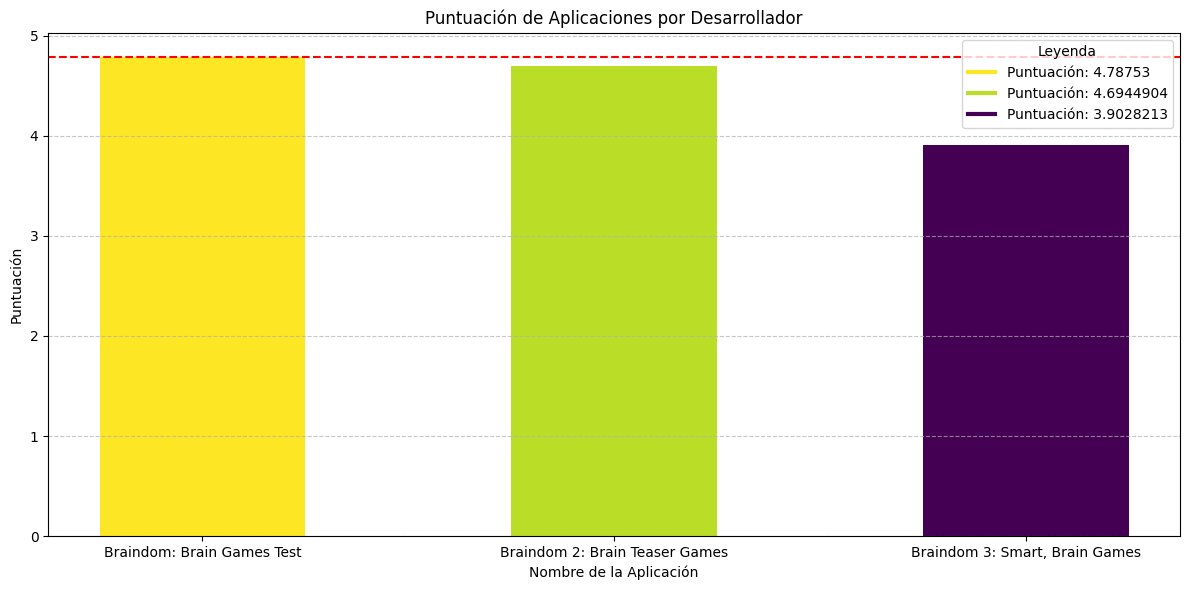

Nombre de la aplicación: Braindom: Brain Games Test
ID de la aplicación: com.braindom
Desarrollador: Matchingham Games
Género: Word
Número total de instalaciones: 10,000,000+
Version actual: 2.1.9
Ultima actualización: 2023-10-25 11:41:29
Puntuación: 4.78753
--------------------------------------------------
Nombre de la aplicación: Braindom 2: Brain Teaser Games
ID de la aplicación: com.braindom2riddle
Desarrollador: Matchingham Games
Género: Word
Número total de instalaciones: 50,000,000+
Version actual: 2.1.0
Ultima actualización: 2023-10-06 16:52:57
Puntuación: 4.6944904
--------------------------------------------------
Nombre de la aplicación: Braindom 3: Smart, Brain Games
ID de la aplicación: com.matchingham.braindom3
Desarrollador: Matchingham Games
Género: Word
Número total de instalaciones: 1,000,000+
Version actual: 1.7.3
Ultima actualización: 2023-10-27 17:45:25
Puntuación: 3.9028213
--------------------------------------------------

Aplicaciones de la misma Empresa: Epic

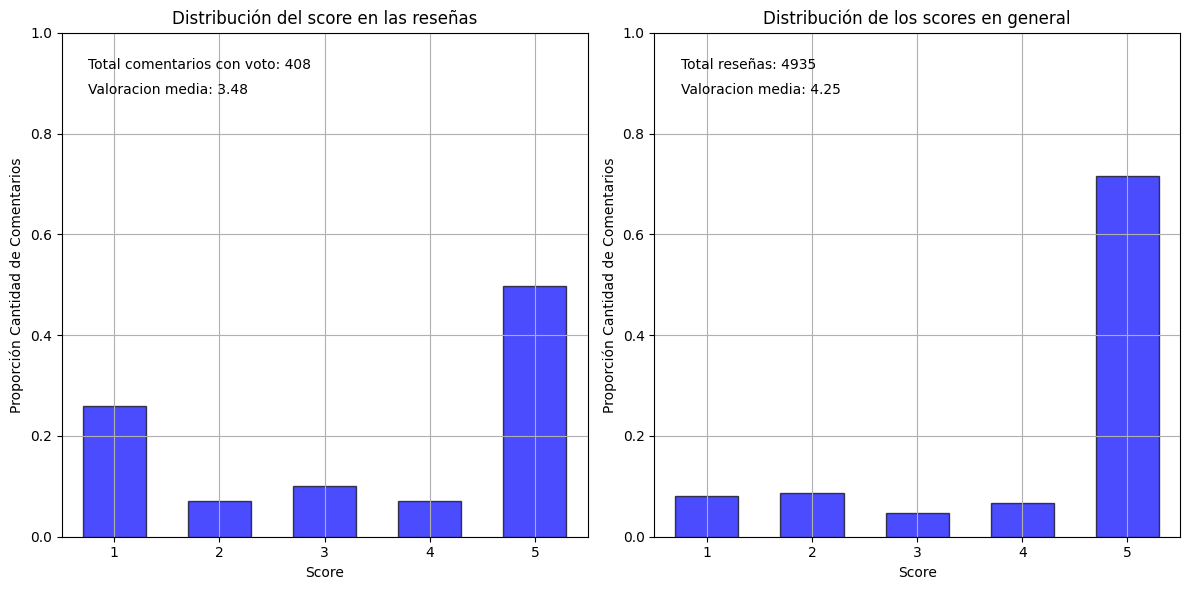

Total de comentarios: 408
Comentarios positivos: 284
Comentarios negativos: 88
Comentarios neutros: 36
Proporción de comentarios positivos: 70.0 %
Proporción de comentarios negativos: 22.0 %
Proporción de comentarios neutros: 9.0 %
                 User                 Date  Score  \
0             Lindsay  2023-07-05 06:12:01      3   
1     Alecia Anderson  2022-09-25 14:42:56      2   
2      Terrie Swisher  2023-10-08 19:08:35      1   
3       Catrina Bland  2023-10-04 16:21:38      2   
4             Andie C  2023-09-08 09:14:34      2   
..                ...                  ...    ...   
514     Autumn Miller  2022-04-21 23:35:33      5   
517  Daniel R Simmons  2022-07-31 10:02:17      5   
520      Pearl Adkins  2022-09-21 09:26:59      5   
521      Nillu Sharma  2022-09-29 10:55:45      5   
527     Danielle Pico  2022-06-26 23:54:56      1   

                                               Content  Helpful Count  \
0    I've enjoyed playing but had issues with space...    

C:\Users\ECOMMERCE\AppData\Local\Temp\ipykernel_21128\3662508612.py:312: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
C:\Users\ECOMMERCE\AppData\Local\Temp\ipykernel_21128\3662508612.py:313: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]


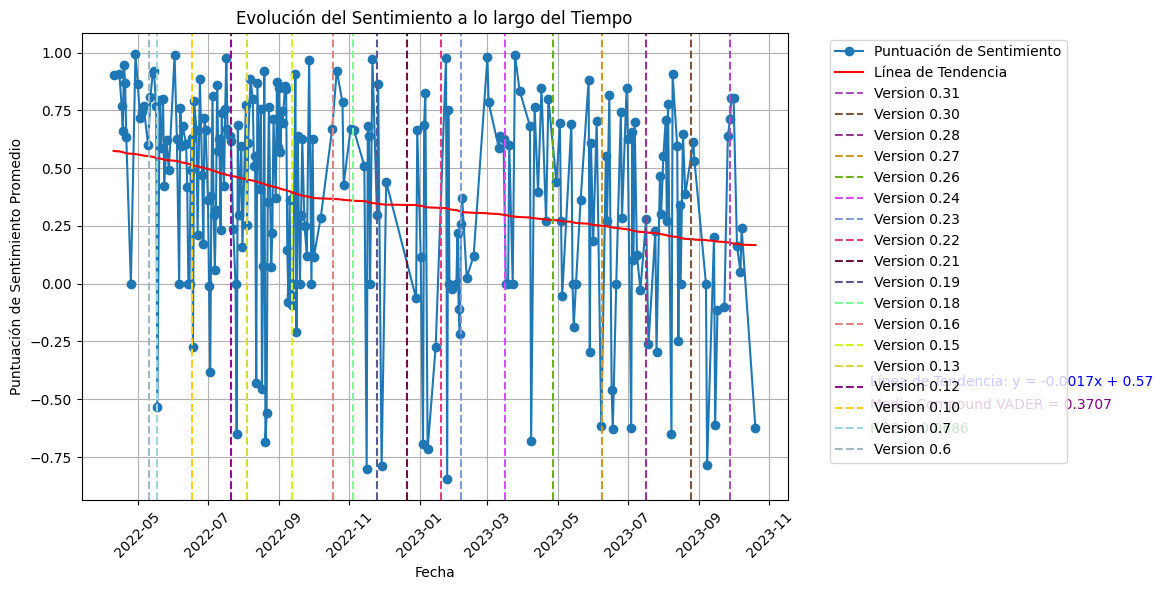

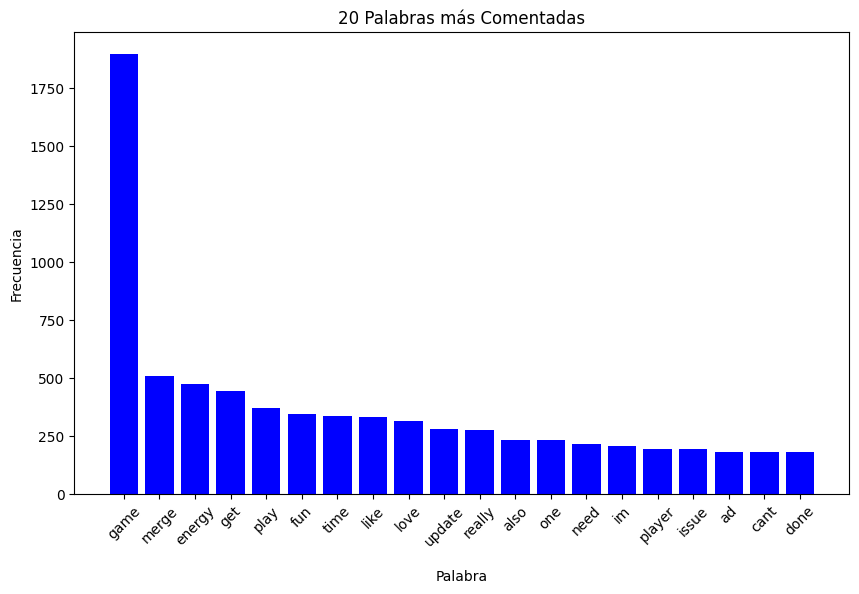

C:\ProgramData\Anaconda3\envs\notebook\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\ProgramData\Anaconda3\envs\notebook\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


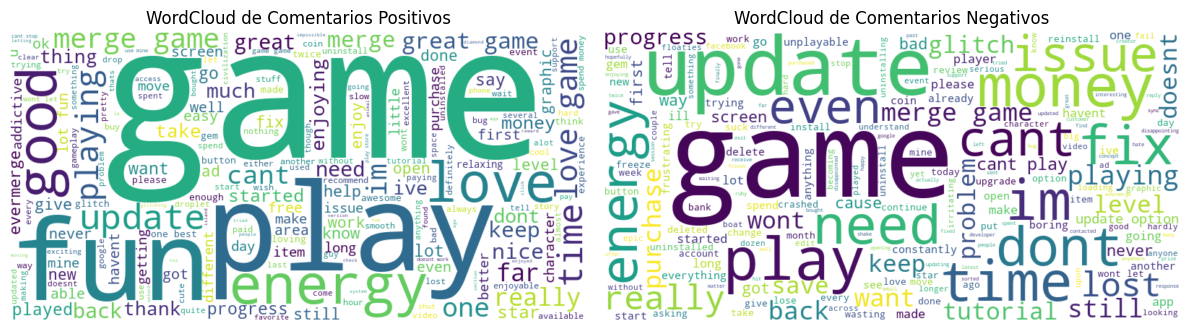

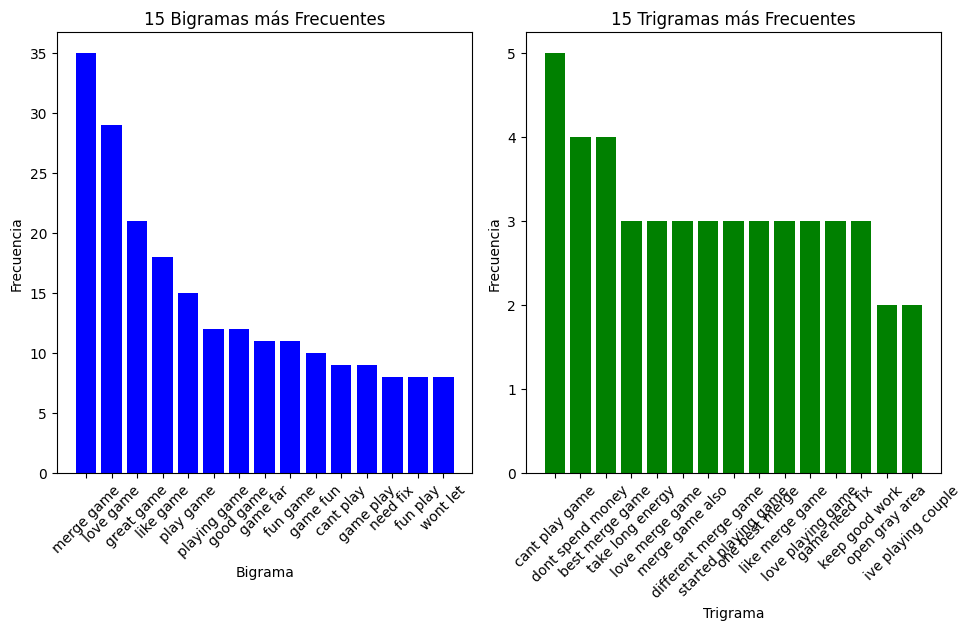

C:\ProgramData\Anaconda3\envs\notebook\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\ProgramData\Anaconda3\envs\notebook\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


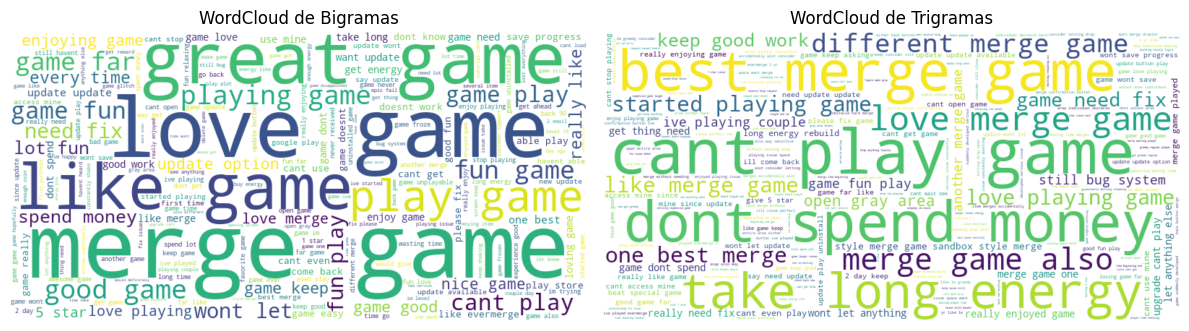

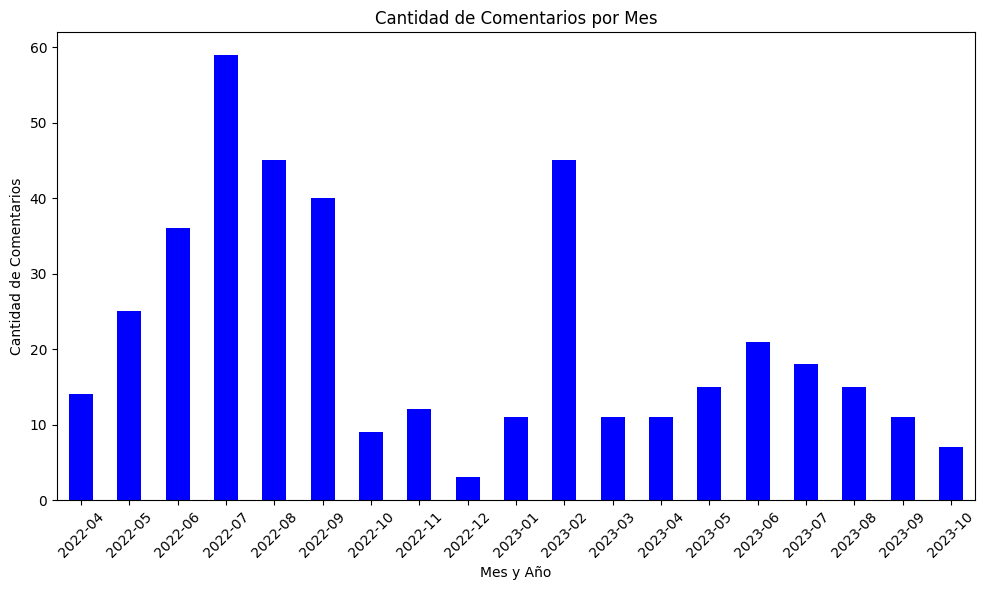


Comentarios filtrados por palabra clave y fecha:
                    User       Date  Score  \
0                Lindsay 2023-07-05      3   
32          Lisa Bartley 2023-06-12      5   
7          April Griffis 2023-08-08      3   
30   Christopher Conover 2023-05-30      1   
12       Kathryn Lambert 2023-06-30      4   
..                   ...        ...    ...   
61       Trudi Smithurst 2023-08-18      2   
2         Terrie Swisher 2023-10-08      1   
67        Loretta Knight 2023-07-19      2   
68          Irene Brewer 2023-07-19      2   
411     Theress Williams 2023-06-26      5   

                                               Content  Helpful Count  \
0    I've enjoyed playing but had issues with space...             12   
32   This game is just like Evermerge! However, I t...              6   
7    There are dozens upon dozens of merge games. I...              4   
30   Completely bug filled. Can't support my screen...              4   
12   This app is extremely glitc

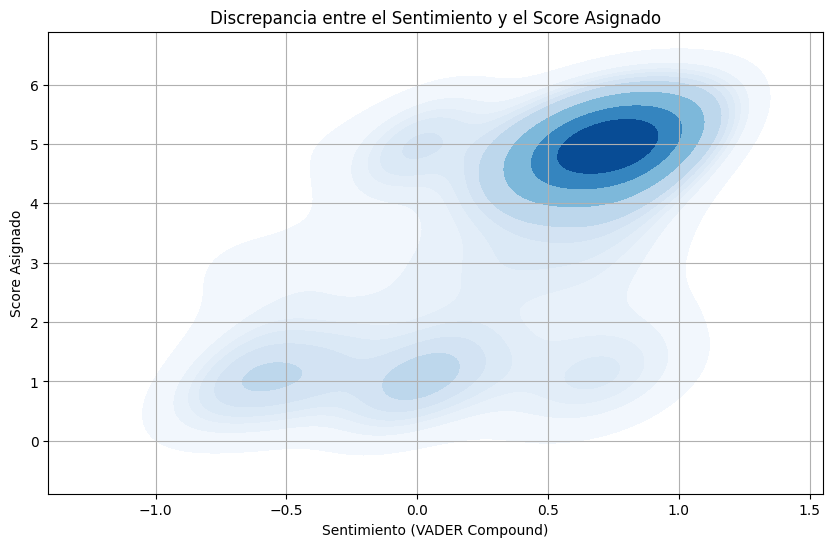

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        27

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

[[55  0]
 [ 0 27]]
Accuracy (Cross-Validation): 1.0
ROC AUC (Cross-Validation): 1.0
Accuracy (SVM): 0.9878048780487805
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        55
           1       0.96      1.00      0.98        27

    accuracy                           0.99        82
   macro avg       0.98      0.99      0.99        82
weighted avg       0.99      0.99      0.99        82

[[54  1]
 [ 0 27]]
Accuracy (Cross-Validation - SVM): 0.9779584462511292
Matriz de Confusión:
[[55  0]
 [ 0 27]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       

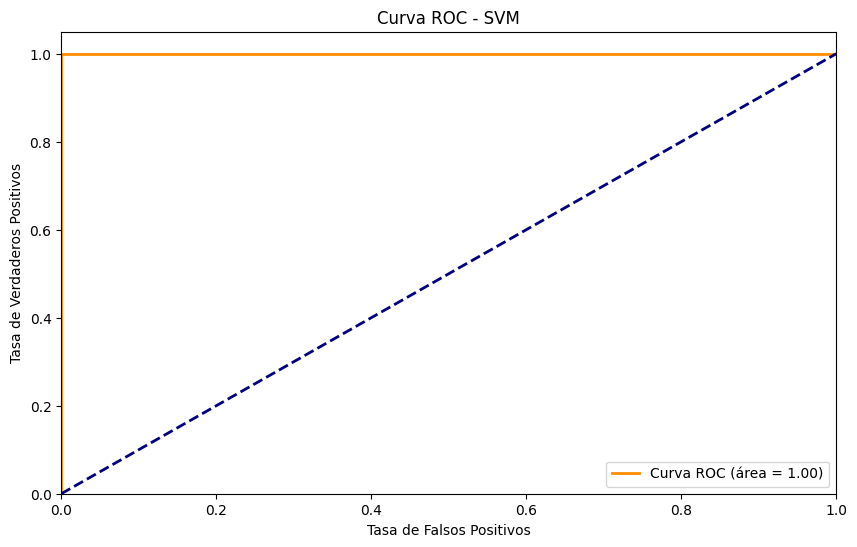

Perplexity: -6.620609523846709
Coherence Score: 0.3661401540399491


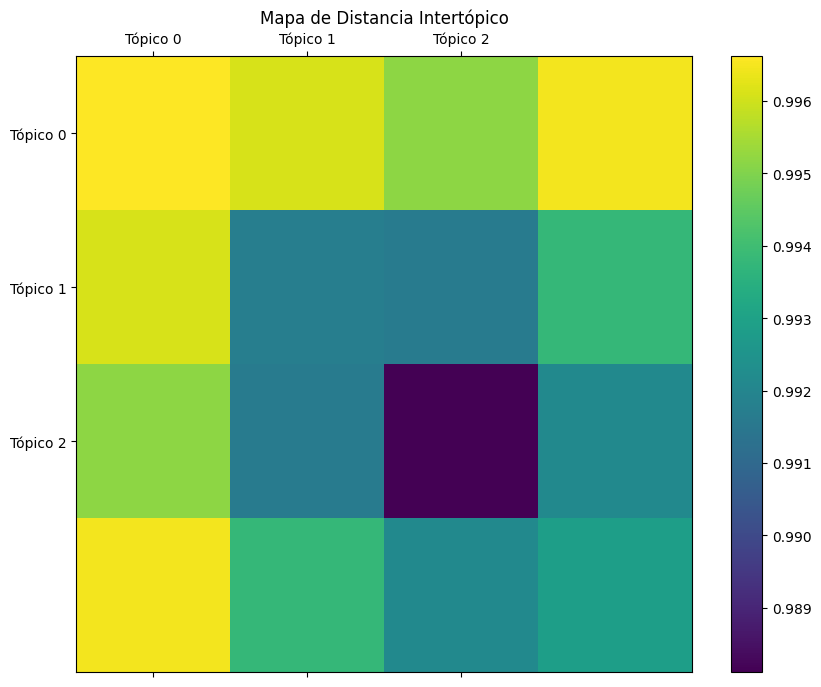

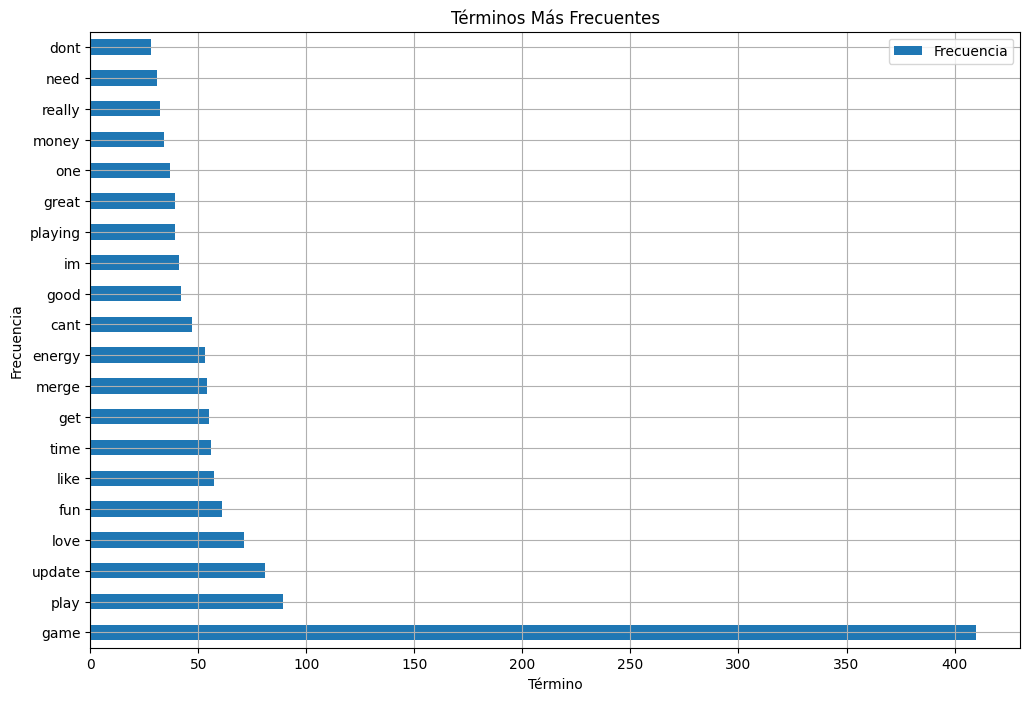

   Topic_0_words  Topic_0_probs Topic_1_words  Topic_1_probs Topic_2_words  \
0         "game"          0.035        "game"          0.065        "game"   
1         "play"          0.013        "play"          0.022      "update"   
2         "time"          0.013         "fun"          0.021        "love"   
3       "update"          0.009        "good"          0.020        "time"   
4         "good"          0.007        "cant"          0.016        "like"   
5           "ok"          0.007         "get"          0.013        "play"   
6       "havent"          0.006        "like"          0.012       "money"   
7           "im"          0.006      "update"          0.011          "im"   
8         "back"          0.006       "merge"          0.011         "get"   
9          "bad"          0.006      "really"          0.010     "playing"   
10        "take"          0.006        "time"          0.009         "fun"   
11        "ever"          0.006        "nice"          0.009    

In [47]:
if __name__ == "__main__":
    main()